In [80]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
import math 
import copy
import time

import pandapower as pp
import pandapower.networks as pn

from numpy import NaN, NAN, nan
import shap 

In [81]:
device = torch.device('cpu')
model = torch.jit.load('loss_model.pt',map_location=device)

In [82]:
data = pd.read_csv("loss_allocation_data.csv", index_col=0)

net = pn.panda_four_load_branch()
net.load.p_mw = [0.05, 0.06, 0.07, 0.08]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:4].copy(),
                                                    data.iloc[:,4:].copy(),
                                                    test_size=0.2, random_state=42)

In [84]:
'''scaler_x = MinMaxScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)'''

'''scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)'''

'scaler_y = MinMaxScaler()\ny_train = scaler_y.fit_transform(y_train)\ny_test = scaler_y.transform(y_test)'

In [85]:

# SHAP Calculation
def model_func(data):
    model.eval()  # ensure the model is in evaluation mode
    data_tensor = torch.from_numpy(data.astype(np.float32))  # convert the numpy array to a torch tensor
    with torch.no_grad():  # turn off gradients for prediction
        output = model(data_tensor)
    return output.cpu().numpy()  # assuming you're using a GPU

background_data = X_train
test_data = X_train


explainer = shap.KernelExplainer(model_func, data=np.linspace([0.0001] * 4, [0.001] * 4, num=10), masker=lambda mask, x: x * mask)
SHAP_values = explainer.shap_values(np.array([net.load.p_mw]))

  0%|          | 0/1 [00:00<?, ?it/s]

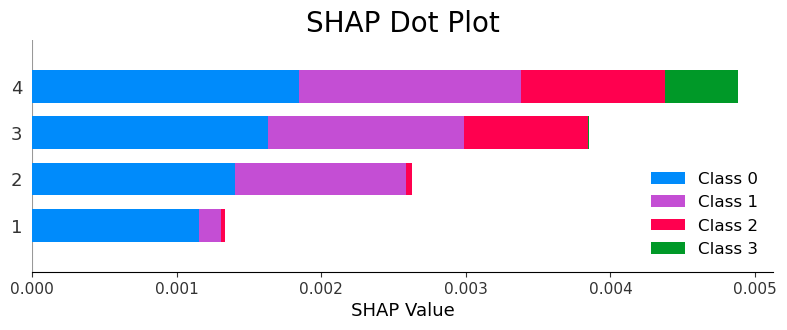

In [86]:
fig = plt.figure(figsize=(8,8))
fig.set_facecolor('white')
ax = fig.add_subplot()
shap.summary_plot(SHAP_values, background_data, 
                  feature_names=[1,2,3,4], ## 변수명 표시
                  cmap='bwr', ## 컬러맵
                  show=False, ## 기존 X축 라벨 표시 안함
                 )
ax.set_xlabel('SHAP Value')
ax.set_title('SHAP Dot Plot', fontsize=20)
plt.show()

In [87]:
compare_index = 0
model_result = [
    sum([SHAP_values[i][compare_index][feat] for i in range(4)])
    for feat in range(4)
]

In [88]:
model_result

[0.0013328117138977772,
 0.002628071218108137,
 0.003854669364227449,
 0.0048805732963955965]

In [89]:
class shapley_calc:
    def __init__(self, net):
        self.net = net
        self.load_num = len(self.net.load)
        self.sgen_num = len(self.net.sgen)
        self.total_player_num = self.load_num+self.sgen_num

    def coalitional_value(self, coalition): # TRUE FALSE COALITION
        self.copy_net = copy.deepcopy(self.net)
        
        # SEPARATE BOOL INDEX
        self.load_bool_idx = coalition[:self.load_num]
        self.sgen_bool_idx = coalition[self.load_num:self.total_player_num]

        self.update_load_list = np.zeros(self.load_num)
        for i, value in enumerate(self.load_bool_idx):
            if value == True:
                self.update_load_list[i] = self.copy_net.load.p_mw[i]
            elif value == False:
                self.update_load_list[i] = 0

        self.update_sgen_list = np.zeros(self.sgen_num)
        for i, value in enumerate(self.sgen_bool_idx):
            if value == True:
                self.update_sgen_list[i] = self.copy_net.sgen.p_mw[i]
            elif value == False:
                
                self.update_sgen_list[i] = 0

        # UPDATE DATA
        self.copy_net.load.p_mw = self.update_load_list
        self.copy_net.sgen.p_mw = self.update_sgen_list

        pp.runpp(self.copy_net)

        return sum(self.copy_net.res_line.pl_mw)

    def component_shapley(self, player):
        self.shapley = 0
        for coalition_number in range(self.total_player_num):
            #print("coal_number : ", coalition_number)
            
            self.numbering_index = list(range(self.total_player_num))
            self.numbering_index.remove(player)

            self.without_i_coalition_list = list(combinations(self.numbering_index, coalition_number))

            for players in list(self.without_i_coalition_list):
                self.bool_list_w_player=np.zeros(self.total_player_num)
                self.bool_list_wo_player=np.zeros(self.total_player_num)
                
                for indexing_number in range(self.total_player_num):
                    if indexing_number in players:
                        self.bool_list_w_player[indexing_number] = True
                        self.bool_list_wo_player[indexing_number] = True
                    else:
                        self.bool_list_w_player[indexing_number] = False
                        self.bool_list_wo_player[indexing_number] = False
                    
                    self.bool_list_w_player[player] = True
                    self.bool_list_wo_player[player] = False

                '''print('coalition_number_wo_player : ',coalition_number)
                print('player : ', player)
                print('bool_w_player : ', self.bool_list_w_player)
                print('bool_wo_player : ', self.bool_list_wo_player)'''

                self.weight = math.factorial(coalition_number)*math.factorial(self.total_player_num-coalition_number-1)/math.factorial(self.total_player_num)
                self.marginal_value = self.coalitional_value(self.bool_list_w_player)-self.coalitional_value(self.bool_list_wo_player)
                self.shapley += self.weight * self.marginal_value
        
        return self.shapley
    
    def shapley_list(self):
        self.shapley_list = np.zeros(self.total_player_num)
        for player in range(self.total_player_num):
            self.shapley_list[player] = self.component_shapley(player=player)
        
        return self.shapley_list

In [92]:
start = time.time()
shapley_calc(net).shapley_list()

array([0.00105553, 0.00228777, 0.00352663, 0.00453684])

In [93]:
model_result

[0.0013328117138977772,
 0.002628071218108137,
 0.003854669364227449,
 0.0048805732963955965]